# PCA Similarity Analysis - Iñigo Martínez (per 100 touches)
## Barcelona - Defensa Central

**Contexto:**
- **Target**: Iñigo Martínez (Barcelona, 24/25)
- **Posición**: CB (Central Defender)
- **Análisis**: Búsqueda de jugadores estadísticamente similares sin target de validación

**Metodología:**
1. **Pool PCA estandarizado**: CB, 1000+ min, max 32 años (Big 5 + Portugal)
2. **Normalización**: per 100 touches
3. **PCA**: 85% varianza retenida
4. **Similitud coseno**: Ranking descendente
5. **Filtro post-PCA**: ≤60M€, ≤26 años

In [1]:
import pandas as pd
import numpy as np
import sys
import os

# Subir dos niveles desde blog/notebooks/ hasta data/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from database.connection import get_db_manager
from tfm.helpers.query_helpers import query_player_pool, add_exogenous_player
from tfm.helpers.algorithms import find_similar_players_cosine

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Pool PCA estandarizado: Big 5 + Portugal
big5_leagues = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']

pools = []
for league in big5_leagues:
    try:
        pool = query_player_pool(
            league=league,
            season='2425',
            positions=['CB'],
            min_minutes=1000,
            max_age=32
        )
        pools.append(pool)
        print(f"{league}: {len(pool)} jugadores")
    except Exception as e:
        print(f"Error en {league}: {e}")

# Add Portugal (table_type='extras')
# positions=['CB'] filtra por transfermarkt_position_specific que SÍ existe en extras
try:
    pool_portugal = query_player_pool(
        league='POR-Primeira Liga',
        season='2425',
        positions=['CB'],
        min_minutes=1000,
        min_age=20,
        max_age=32,
        table_type='extras'
    )
    pools.append(pool_portugal)
    print(f"POR-Primeira Liga: {len(pool_portugal)} jugadores")
except Exception as e:
    print(f"Error en Portugal: {e}")

pool_df = pd.concat(pools, ignore_index=True)

print(f"\nPool PCA (estandarizado): {len(pool_df)} jugadores")
print(f"\nDistribución por liga:")
print(pool_df['league'].value_counts())

2026-01-30 11:33:14,505 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-30 11:33:14,778 - database.connection - INFO - Database connection successful
2026-01-30 11:33:14,913 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-30 11:33:14,951 - database.connection - INFO - Database connection successful
2026-01-30 11:33:15,044 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-30 11:33:15,075 - database.connection - INFO - Database connection successful


ENG-Premier League: 53 jugadores
ESP-La Liga: 47 jugadores


2026-01-30 11:33:15,186 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-30 11:33:15,213 - database.connection - INFO - Database connection successful
2026-01-30 11:33:15,297 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-30 11:33:15,331 - database.connection - INFO - Database connection successful


ITA-Serie A: 64 jugadores
GER-Bundesliga: 60 jugadores


2026-01-30 11:33:15,426 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-30 11:33:15,456 - database.connection - INFO - Database connection successful


FRA-Ligue 1: 45 jugadores
POR-Primeira Liga: 37 jugadores

Pool PCA (estandarizado): 306 jugadores

Distribución por liga:
league
ITA-Serie A           64
GER-Bundesliga        60
ENG-Premier League    53
ESP-La Liga           47
FRA-Ligue 1           45
POR-Primeira Liga     37
Name: count, dtype: int64


In [3]:
# Verificar si Iñigo Martínez ya está en el pool
inigo_in_pool = pool_df[pool_df['player_name'].str.contains('Iñigo Martínez|Inigo Martinez', case=False, na=False)]

if len(inigo_in_pool) > 0:
    print("Iñigo Martínez ya está en el pool:")
    print(inigo_in_pool[['player_name', 'team', 'league', 'age']].to_string(index=False))
    full_df = pool_df.copy()
else:
    print("Añadiendo Iñigo Martínez como jugador exógeno...")
    full_df = add_exogenous_player(
        pool_df=pool_df,
        player_name='Iñigo Martínez',
        league='ESP-La Liga',
        season='2425',
        team='Barcelona'
    )

print(f"\nDataFrame total: {len(full_df)} jugadores")

2026-01-30 11:33:15,557 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-30 11:33:15,585 - database.connection - INFO - Database connection successful


Añadiendo Iñigo Martínez como jugador exógeno...
Added exogenous player: Iñigo Martínez (Barcelona, ESP-La Liga 2425)
Total players in DataFrame: 307

DataFrame total: 307 jugadores


In [4]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    if value is None or pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.strip() == '' or value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    return np.nan

fbref_nums = extract_metrics(full_df, 'fbref_metrics')
understat_nums = extract_metrics(full_df, 'understat_metrics')
transfermarkt_nums = extract_metrics(full_df, 'transfermarkt_metrics')

print(f"FBref: {fbref_nums.shape[1]} métricas")
print(f"Understat: {understat_nums.shape[1]} métricas")
print(f"Transfermarkt: {transfermarkt_nums.shape[1]} campos")

FBref: 185 métricas
Understat: 10 métricas
Transfermarkt: 2 campos


In [5]:
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches'
}

# Normalización per 100 touches
touches = fbref_nums['Touches_Touches']

fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(touches, axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(touches, axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches FBref: {fbref_per100.shape[1]} columnas")
print(f"Per100touches Understat: {understat_per100.shape[1]} columnas")

Per100touches FBref: 183 columnas
Per100touches Understat: 10 columnas


In [6]:
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position', 'age']

df_final = pd.concat([
    full_df[base_cols],
    fbref_nums,
    understat_nums,
    transfermarkt_nums,
    fbref_per100,
    understat_per100
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} jugadores × {df_final.shape[1]} columnas")

DataFrame final: 307 jugadores × 397 columnas


In [7]:
# Identificar target: Iñigo Martínez
target = df_final[df_final['player_name'].str.contains('Iñigo Martínez|Inigo Martinez', case=False, na=False)]
target = target[target['team'].str.contains('Barcelona', case=False, na=False)]

if len(target) == 0:
    raise ValueError("Iñigo Martínez no encontrado en el pool")

target_id = target.iloc[0]['unique_player_id']

print(f"Target: {target.iloc[0]['player_name']}")
print(f"  Equipo: {target.iloc[0]['team']}")
print(f"  Liga: {target.iloc[0]['league']}")
print(f"  Edad: {target.iloc[0]['age']}")
print(f"  ID: {target_id}")

Target: Iñigo Martínez
  Equipo: Barcelona
  Liga: ESP-La Liga
  Edad: 33
  ID: 63ab52f210f142e9


In [8]:
# Ejecutar algoritmo PCA + similitud coseno
result = find_similar_players_cosine(
    df=df_final,
    target_player_id=target_id,
    n_similar=30,
    pca_variance=0.85,
    replacement_id=None,
    robust_scaling=False,
    return_all_scores=True
)

print(f"PCA completado")
print(f"Componentes: {result.get('n_components', 'N/A')}")
print(f"Varianza explicada: {result.get('explained_variance', 'N/A')}")

Target: Iñigo Martínez (Barcelona, ESP-La Liga)
Features: 170 (per 100 touches, excl. GK)
Jugadores: 307 (eliminados 0 con NaNs CORE)
PCA: 33 componentes (varianza: 85.5%)
Reducción: 170 → 33 dimensiones
Top-30 encontrados
Rango similitud: [0.5728, 0.8484]
PCA completado
Componentes: N/A
Varianza explicada: N/A


In [9]:
# Función para obtener valor de mercado
def get_market_value(player_id):
    player_row = full_df[full_df['unique_player_id'] == player_id]
    if len(player_row) == 0:
        return None
    tm_metrics = player_row.iloc[0].get('transfermarkt_metrics')
    if isinstance(tm_metrics, dict):
        val = tm_metrics.get('transfermarkt_market_value_eur')
        return float(val) / 1_000_000 if val else None
    return None

def get_age(player_id):
    player_row = full_df[full_df['unique_player_id'] == player_id]
    if len(player_row) == 0:
        return None
    return player_row.iloc[0].get('age')

# Obtener todos los scores
similar_df = result['similar_players'].copy()
similar_df['market_value_m'] = similar_df['unique_player_id'].apply(get_market_value)
similar_df['age'] = similar_df['unique_player_id'].apply(get_age)

print("TOP 30 - Pool Completo (sin filtros) - PER 100 TOUCHES")
print("="*90)
print(similar_df[['rank', 'player_name', 'team', 'league', 'age', 'market_value_m', 'cosine_similarity']].head(30).to_string(index=False))

# Filtrar por restricciones de mercado
MAX_VALUE = 60  # Millones €
MAX_AGE_FILTER = 26  # Años

all_scores_df = result['all_scores'].copy()
all_scores_df['market_value_m'] = all_scores_df['unique_player_id'].apply(get_market_value)
all_scores_df['age'] = all_scores_df['unique_player_id'].apply(get_age)

pool_filtrado = all_scores_df[
    (all_scores_df['market_value_m'] <= MAX_VALUE) &
    (all_scores_df['age'] <= MAX_AGE_FILTER)
].copy()

pool_filtrado = pool_filtrado.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)
pool_filtrado['rank_filtrado'] = range(1, len(pool_filtrado) + 1)

print(f"\n\nTOP 15 - Pool Filtrado (≤{MAX_VALUE}M€, ≤{MAX_AGE_FILTER} años) - PER 100 TOUCHES")
print("="*90)
print(f"Total jugadores en pool filtrado: {len(pool_filtrado)}")
print("\n" + pool_filtrado[['rank_filtrado', 'player_name', 'team', 'league', 'age', 'market_value_m', 'cosine_similarity']].head(15).to_string(index=False))

TOP 30 - Pool Completo (sin filtros) - PER 100 TOUCHES
 rank        player_name            team             league  age  market_value_m  cosine_similarity
    1      Manuel Akanji Manchester City ENG-Premier League   29            28.0           0.848388
    2     Edmond Tapsoba      Leverkusen     GER-Bundesliga   25            35.0           0.807332
    3         Rúben Dias Manchester City ENG-Premier League   27            65.0           0.794101
    4        Pau Cubarsí       Barcelona        ESP-La Liga   17            80.0           0.785537
    5         Marquinhos       Paris S-G        FRA-Ligue 1   30            35.0           0.773732
    6     Gonçalo Inácio     Sporting CP  POR-Primeira Liga   22            45.0           0.765431
    7 Jan Paul van Hecke        Brighton ENG-Premier League   24            32.0           0.758780
    8        Sam Beukema         Bologna        ITA-Serie A   25            28.0           0.749505
    9    Ibrahima Konaté       Liverpool ENG-

In [10]:
# Top 10 con contexto
print("\nTOP 10 - Análisis detallado (per 100 touches)")
print("="*90)

for i, row in similar_df.head(10).iterrows():
    print(f"\n#{row['rank']} {row['player_name']} ({row['team']}, {row['league']})")
    print(f"   Edad: {row['age']} | Valor: {row['market_value_m']:.1f}M€ | Similitud: {row['cosine_similarity']:.4f}")


TOP 10 - Análisis detallado (per 100 touches)

#1 Manuel Akanji (Manchester City, ENG-Premier League)
   Edad: 29 | Valor: 28.0M€ | Similitud: 0.8484

#2 Edmond Tapsoba (Leverkusen, GER-Bundesliga)
   Edad: 25 | Valor: 35.0M€ | Similitud: 0.8073

#3 Rúben Dias (Manchester City, ENG-Premier League)
   Edad: 27 | Valor: 65.0M€ | Similitud: 0.7941

#4 Pau Cubarsí (Barcelona, ESP-La Liga)
   Edad: 17 | Valor: 80.0M€ | Similitud: 0.7855

#5 Marquinhos (Paris S-G, FRA-Ligue 1)
   Edad: 30 | Valor: 35.0M€ | Similitud: 0.7737

#6 Gonçalo Inácio (Sporting CP, POR-Primeira Liga)
   Edad: 22 | Valor: 45.0M€ | Similitud: 0.7654

#7 Jan Paul van Hecke (Brighton, ENG-Premier League)
   Edad: 24 | Valor: 32.0M€ | Similitud: 0.7588

#8 Sam Beukema (Bologna, ITA-Serie A)
   Edad: 25 | Valor: 28.0M€ | Similitud: 0.7495

#9 Ibrahima Konaté (Liverpool, ENG-Premier League)
   Edad: 25 | Valor: 60.0M€ | Similitud: 0.7436

#10 Waldemar Anton (Dortmund, GER-Bundesliga)
   Edad: 28 | Valor: 18.0M€ | Similitud

Visualización guardada: /home/jaime/FD/data/blog/notebooks/inigo_martinez_top10_filtrado.png


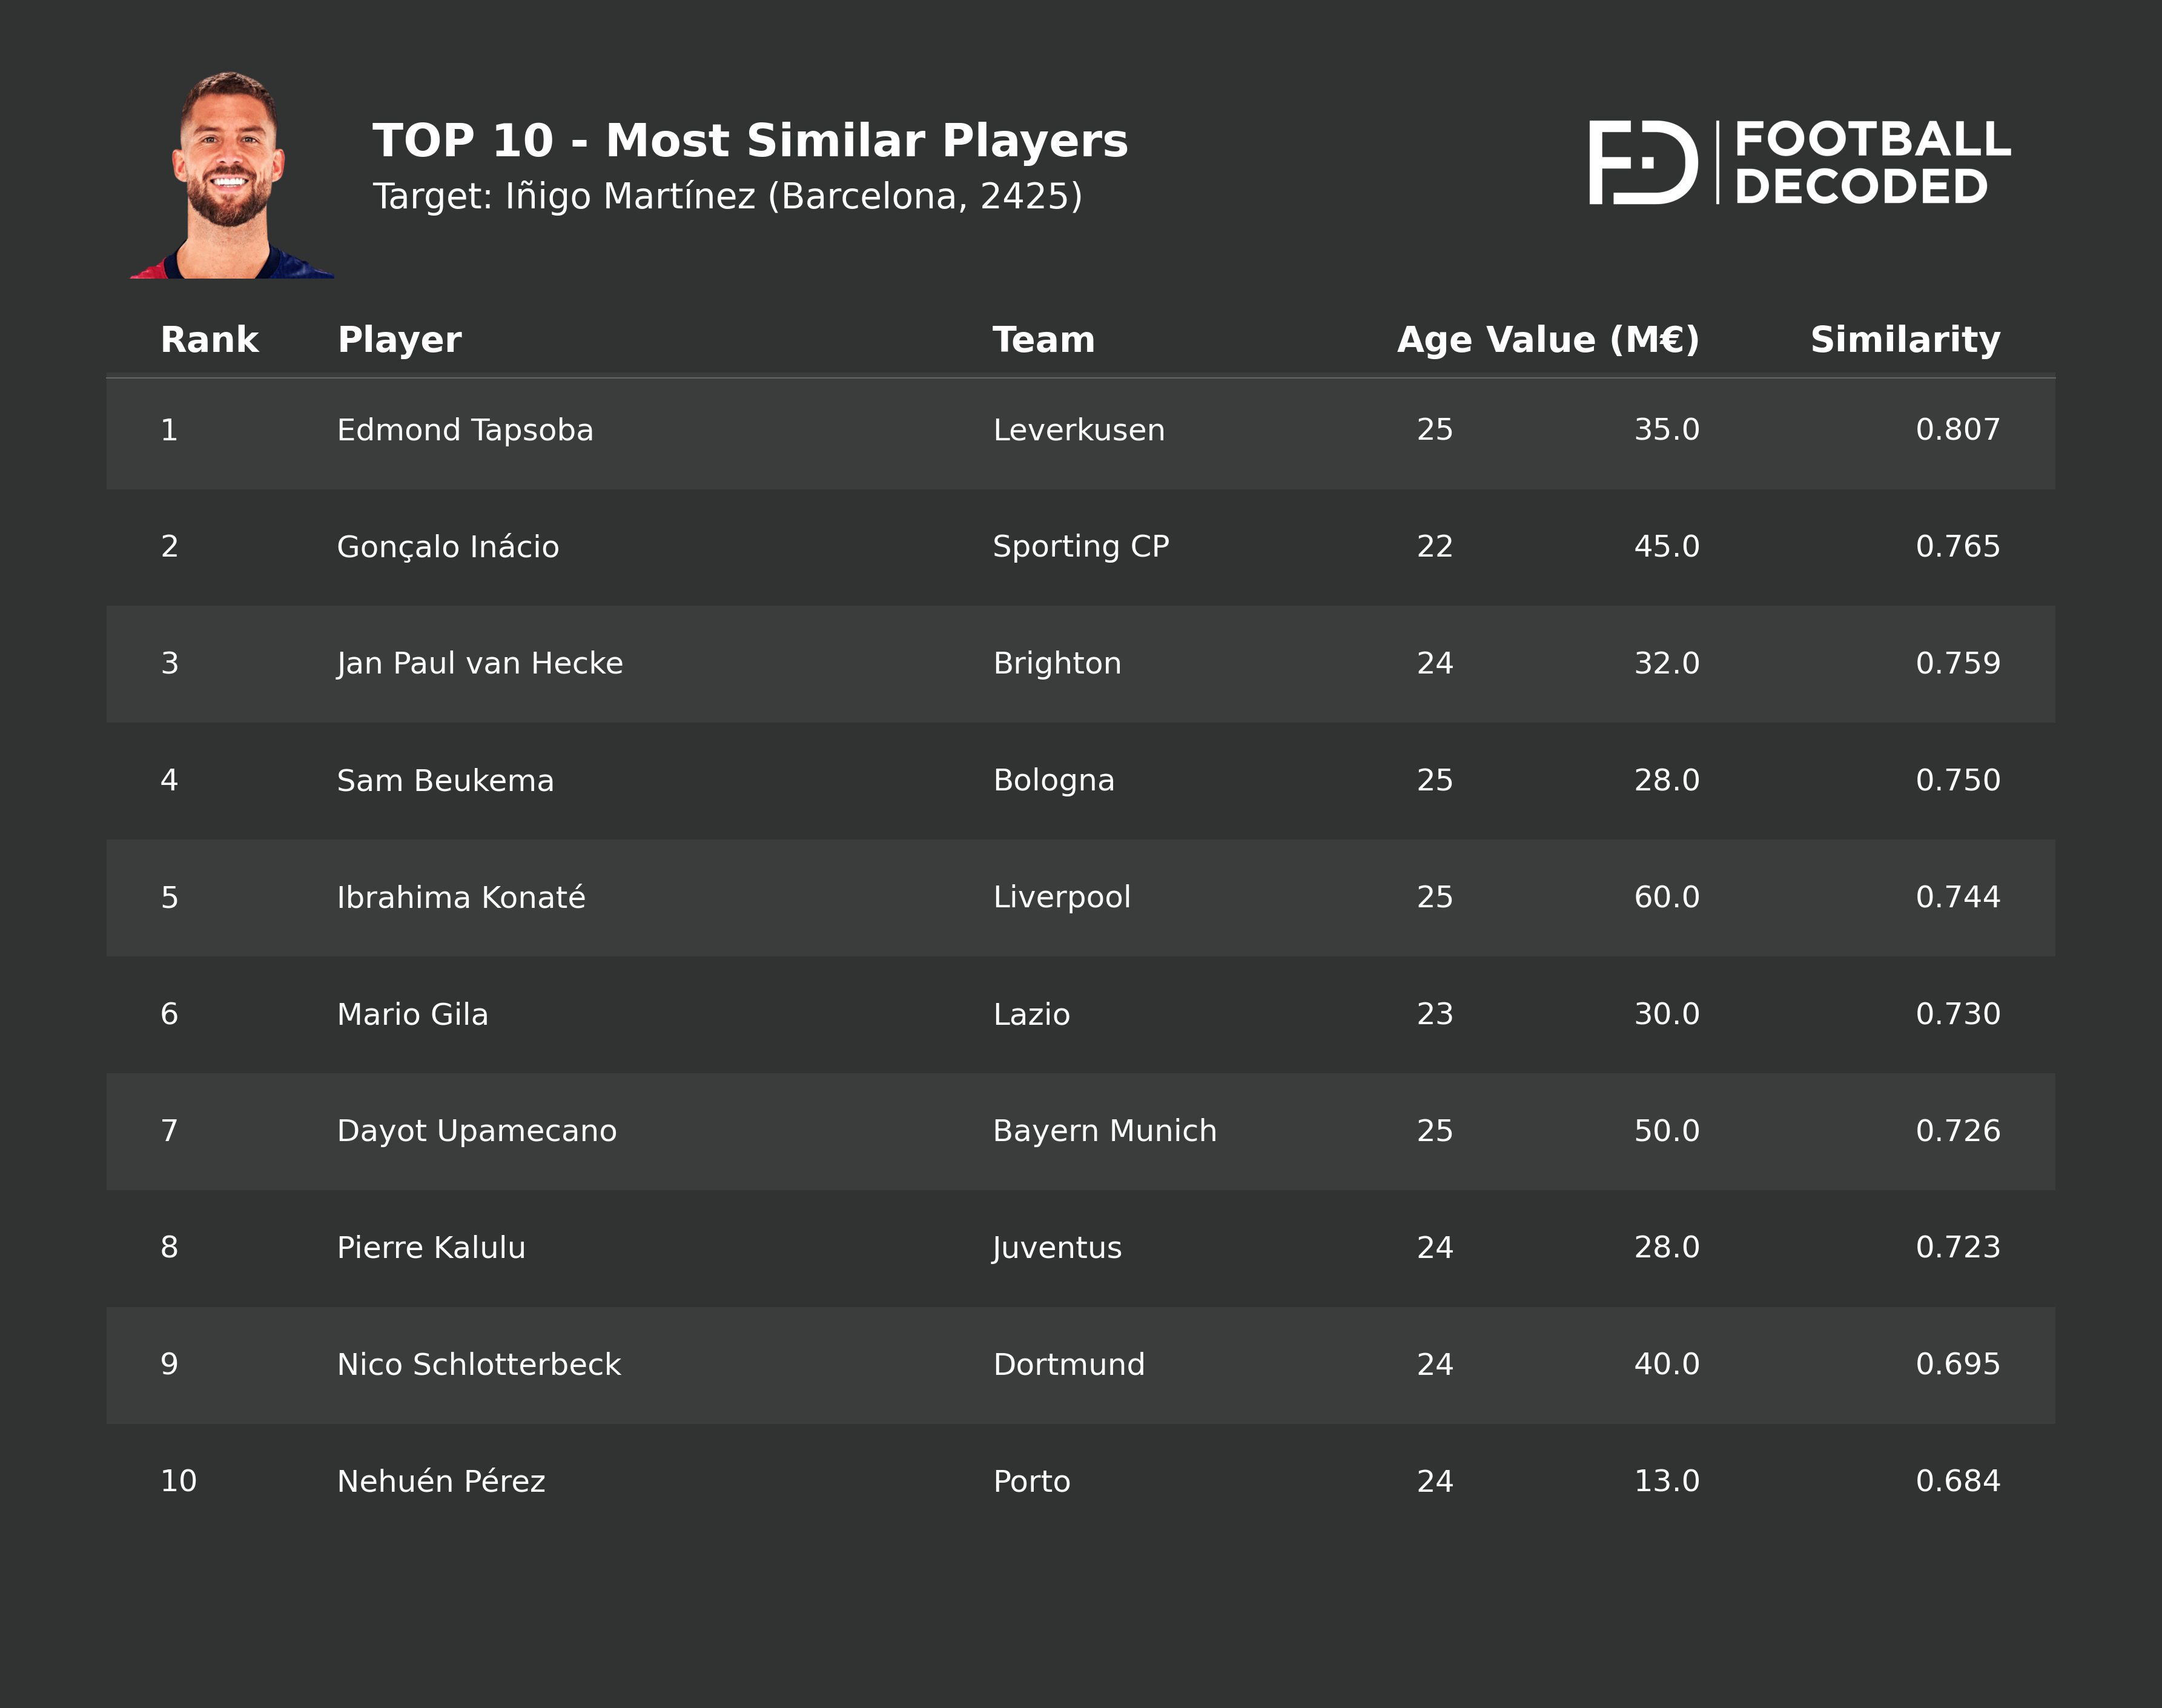

In [11]:
from tfm.helpers.viz_helpers import plot_top10_ranking

# Preparar pool filtrado para visualización
pool_viz = pool_filtrado.copy()
if 'rank' in pool_viz.columns:
    pool_viz = pool_viz.drop(columns=['rank'])
pool_viz = pool_viz.rename(columns={'rank_filtrado': 'rank'})
pool_viz = pool_viz.drop(columns=['age', 'market_value_m'])

result_filtrado = result.copy()
result_filtrado['similar_players'] = pool_viz

# Visualización top 10 del pool filtrado con cara de Iñigo
output_path = plot_top10_ranking(
    result=result_filtrado,
    df_data=full_df,
    save_path='inigo_martinez_top10_filtrado.png',
    target_face_path='../../blog/caras/iñigo.png',
    highlight_target=False,
    dpi=300
)

print(f"Visualización guardada: {output_path}")

from IPython.display import Image, display
display(Image(filename=output_path))

In [12]:
# Distribución de similitudes
dist = result['score_distribution']

print("\nDISTRIBUCIÓN DE SIMILITUDES (per 100 touches)")
print("="*50)
print(f"Mínimo:   {dist['min']:.4f}")
print(f"Q5:       {dist['q5']:.4f}")
print(f"Q25:      {dist['q25']:.4f}")
print(f"Mediana:  {dist['median']:.4f}")
print(f"Q75:      {dist['q75']:.4f}")
print(f"Q95:      {dist['q95']:.4f}")
print(f"Máximo:   {dist['max']:.4f}")
print(f"Media:    {dist['mean']:.4f}")
print(f"Desv.Est: {dist['std']:.4f}")


DISTRIBUCIÓN DE SIMILITUDES (per 100 touches)
Mínimo:   -0.6807
Q5:       -0.5484
Q25:      -0.2857
Mediana:  -0.0140
Q75:      0.3370
Q95:      0.6924
Máximo:   0.8484
Media:    0.0241
Desv.Est: 0.3862
